In [11]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

In [12]:
import heapq

In [13]:
class BGPRouter:
    def __init__(self, as_number):
        self.as_number = as_number
        self.neighbors = []
        self.routing_table = {}
        self.routing_table[as_number] = ([as_number], 0)
    
    def add_neighbor(self, neighbor_as):
        if neighbor_as not in self.neighbors:
            self.neighbors.append(neighbor_as)
    
    def update_routing_table(self, dest_as, path, cost):
        if self.as_number in path:
            return False
        
        new_path = [self.as_number] + path
        new_cost = cost + 1
        
        if dest_as not in self.routing_table:
            self.routing_table[dest_as] = (new_path, new_cost)
            return True
        else:
            current_path, current_cost = self.routing_table[dest_as]
            
            if new_cost < current_cost:
                self.routing_table[dest_as] = (new_path, new_cost)
                return True
            elif new_cost == current_cost and len(new_path) < len(current_path):
                self.routing_table[dest_as] = (new_path, new_cost)
                return True
        
        return False
    
    def get_routes(self):
        return self.routing_table.copy()
    
    def display_routing_table(self):
        print(f"\nBGP Routing Table for AS {self.as_number}:")
        print("-" * 70)
        print(f"{'Destination AS':<20} {'AS Path':<35} {'Path Length':<15}")
        print("-" * 70)
        for dest_as in sorted(self.routing_table.keys()):
            path, cost = self.routing_table[dest_as]
            path_str = ' -> '.join(map(str, path))
            print(f"{dest_as:<20} {path_str:<35} {len(path)-1:<15}")
        print("-" * 70)

In [14]:
class IntraASRouter:
    def __init__(self, router_id, as_number):
        self.router_id = router_id
        self.as_number = as_number
        self.neighbors = {}
        self.routing_table = {}
    
    def add_neighbor(self, neighbor_id, cost):
        self.neighbors[neighbor_id] = cost
    
    def dijkstra(self, all_routers):
        distances = {r.router_id: float('inf') for r in all_routers.values() if r.as_number == self.as_number}
        distances[self.router_id] = 0
        next_hops = {}
        visited = set()
        pq = [(0, self.router_id)]
        
        while pq:
            current_dist, current = heapq.heappop(pq)
            
            if current in visited:
                continue
            
            visited.add(current)
            
            if current in all_routers:
                for neighbor, cost in all_routers[current].neighbors.items():
                    if neighbor not in visited and neighbor in distances:
                        new_dist = current_dist + cost
                        if new_dist < distances[neighbor]:
                            distances[neighbor] = new_dist
                            next_hops[neighbor] = current if current != self.router_id else neighbor
                            heapq.heappush(pq, (new_dist, neighbor))
        
        self.routing_table = {}
        for dest, dist in distances.items():
            if dest != self.router_id and dist != float('inf'):
                self.routing_table[dest] = (dist, next_hops.get(dest, dest))
        
        return distances

In [15]:
def simulate_bgp(as_topology):
    routers = {}
    
    all_as = set()
    for as_num in as_topology.keys():
        all_as.add(as_num)
    for as_num, neighbors in as_topology.items():
        for neighbor in neighbors:
            all_as.add(neighbor)
    
    for as_num in all_as:
        routers[as_num] = BGPRouter(as_num)
    
    for as_num, neighbors in as_topology.items():
        for neighbor in neighbors:
            routers[as_num].add_neighbor(neighbor)
            if neighbor in routers:
                routers[neighbor].add_neighbor(as_num)
    
    print("Starting BGP Simulation...")
    print("=" * 70)
    print("\nAS Topology:")
    for as_num in sorted(routers.keys()):
        neighbors = ', '.join(map(str, sorted(routers[as_num].neighbors)))
        print(f"AS {as_num} peers with: {neighbors}")
    
    max_iterations = 20
    iteration = 0
    
    print("\n" + "=" * 70)
    print("BGP UPDATE Message Exchange")
    print("=" * 70)
    
    while iteration < max_iterations:
        iteration += 1
        updated = False
        
        print(f"\n--- Round {iteration} ---")
        
        for as_num, router in routers.items():
            routes = router.get_routes()
            
            for neighbor_as in router.neighbors:
                if neighbor_as in routers:
                    for dest_as, (path, cost) in routes.items():
                        if dest_as != neighbor_as:
                            if routers[neighbor_as].update_routing_table(dest_as, path, cost):
                                updated = True
                                print(f"AS {as_num} -> AS {neighbor_as}: Route to AS {dest_as} via {path}")
        
        if not updated:
            print(f"\nBGP Converged after {iteration} rounds!")
            break
    
    print("\n" + "=" * 70)
    print("FINAL BGP ROUTING TABLES")
    print("=" * 70)
    
    for as_num in sorted(routers.keys()):
        routers[as_num].display_routing_table()
    
    return routers

In [16]:
def visualize_as_topology(as_topology):
    G = nx.Graph()
    
    for as_num, neighbors in as_topology.items():
        for neighbor in neighbors:
            G.add_edge(f"AS{as_num}", f"AS{neighbor}")
    
    pos = nx.spring_layout(G, seed=42, k=2)
    plt.figure(figsize=(14, 10))
    
    nx.draw_networkx_nodes(G, pos, node_color='lightyellow', 
                          node_size=2000, alpha=0.9, 
                          edgecolors='black', linewidths=2)
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=3, alpha=0.6, edge_color='blue')
    
    plt.title("BGP Autonomous System Topology", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [17]:
def visualize_as_path(routers, source_as, dest_as):
    if dest_as not in routers[source_as].routing_table:
        print(f"No path from AS {source_as} to AS {dest_as}")
        return
    
    path, cost = routers[source_as].routing_table[dest_as]
    
    G = nx.DiGraph()
    for i in range(len(path) - 1):
        G.add_edge(f"AS{path[i]}", f"AS{path[i+1]}")
    
    all_as = set()
    for router in routers.values():
        all_as.add(f"AS{router.as_number}")
    
    for node in all_as:
        if node not in G.nodes():
            G.add_node(node)
    
    pos = nx.spring_layout(G, seed=42, k=2)
    plt.figure(figsize=(12, 8))
    
    node_colors = ['lightgreen' if node == f"AS{source_as}" 
                   else 'lightcoral' if node == f"AS{dest_as}"
                   else 'lightyellow' for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=2000, alpha=0.9,
                          edgecolors='black', linewidths=2)
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')
    
    path_edges = [(f"AS{path[i]}", f"AS{path[i+1]}") for i in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, path_edges, width=4, alpha=0.8, 
                          edge_color='red', arrows=True, 
                          arrowsize=20, arrowstyle='->')
    
    plt.title(f"AS Path from AS{source_as} to AS{dest_as}\nPath: {' -> '.join(map(str, path))}", 
             fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

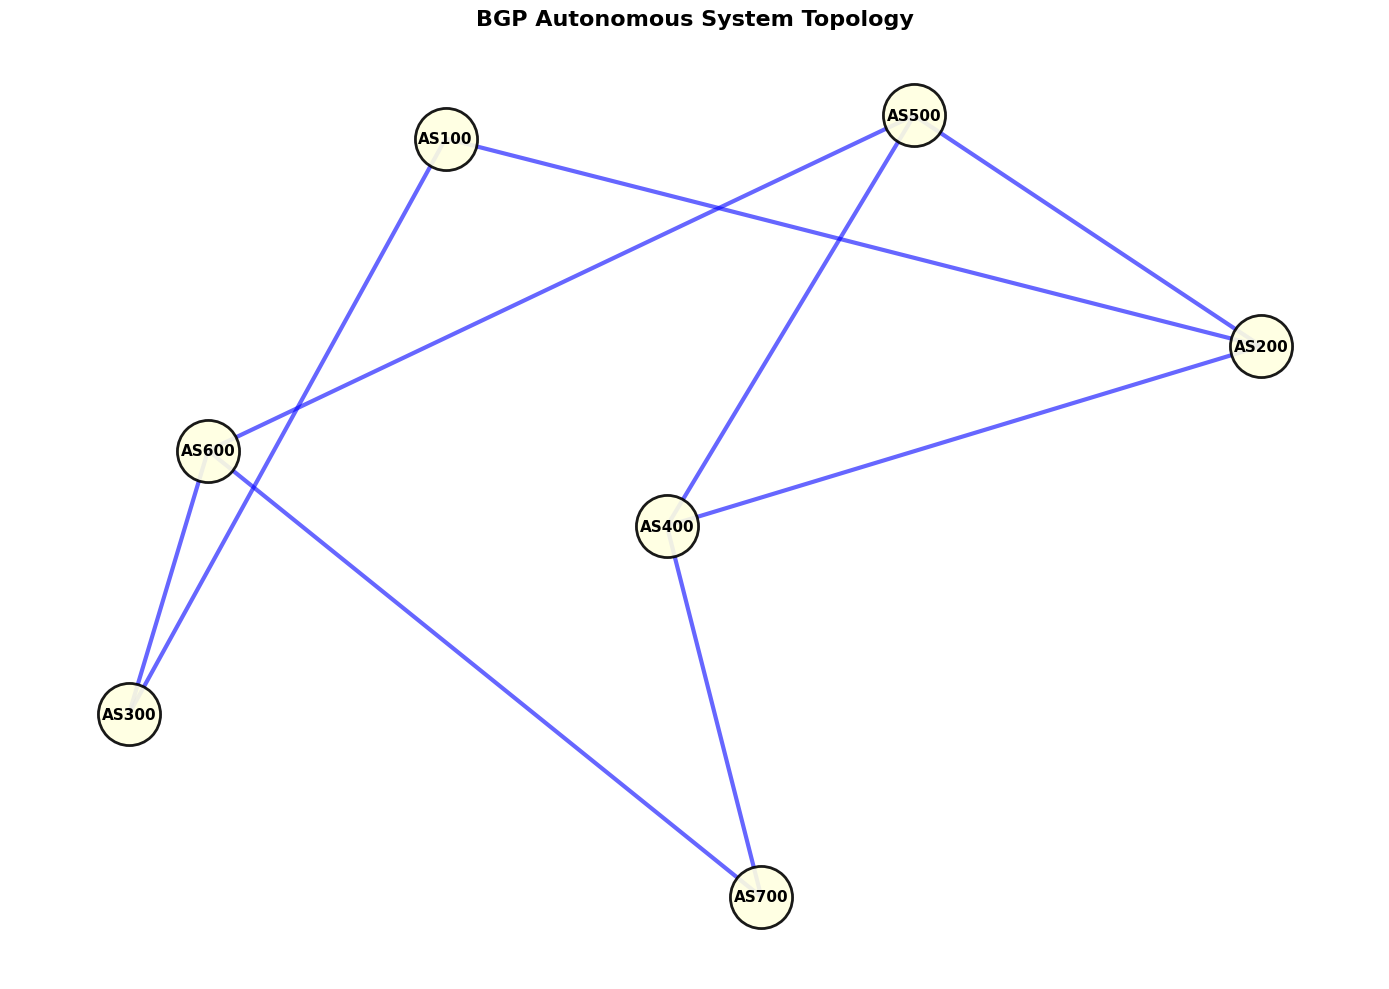

In [18]:
as_topology = {
    100: [200, 300],
    200: [100, 400, 500],
    300: [100, 600],
    400: [200, 500, 700],
    500: [200, 400, 600],
    600: [300, 500, 700],
    700: [400, 600]
}

visualize_as_topology(as_topology)

In [19]:
routers = simulate_bgp(as_topology)

Starting BGP Simulation...

AS Topology:
AS 100 peers with: 200, 300
AS 200 peers with: 100, 400, 500
AS 300 peers with: 100, 600
AS 400 peers with: 200, 500, 700
AS 500 peers with: 200, 400, 600
AS 600 peers with: 300, 500, 700
AS 700 peers with: 400, 600

BGP UPDATE Message Exchange

--- Round 1 ---
AS 100 -> AS 200: Route to AS 100 via [100]
AS 100 -> AS 300: Route to AS 100 via [100]
AS 200 -> AS 100: Route to AS 200 via [200]
AS 200 -> AS 400: Route to AS 200 via [200]
AS 200 -> AS 400: Route to AS 100 via [200, 100]
AS 200 -> AS 500: Route to AS 200 via [200]
AS 200 -> AS 500: Route to AS 100 via [200, 100]
AS 300 -> AS 100: Route to AS 300 via [300]
AS 300 -> AS 600: Route to AS 300 via [300]
AS 300 -> AS 600: Route to AS 100 via [300, 100]
AS 400 -> AS 200: Route to AS 400 via [400]
AS 400 -> AS 500: Route to AS 400 via [400]
AS 400 -> AS 700: Route to AS 400 via [400]
AS 400 -> AS 700: Route to AS 200 via [400, 200]
AS 400 -> AS 700: Route to AS 100 via [400, 200, 100]
AS 500 

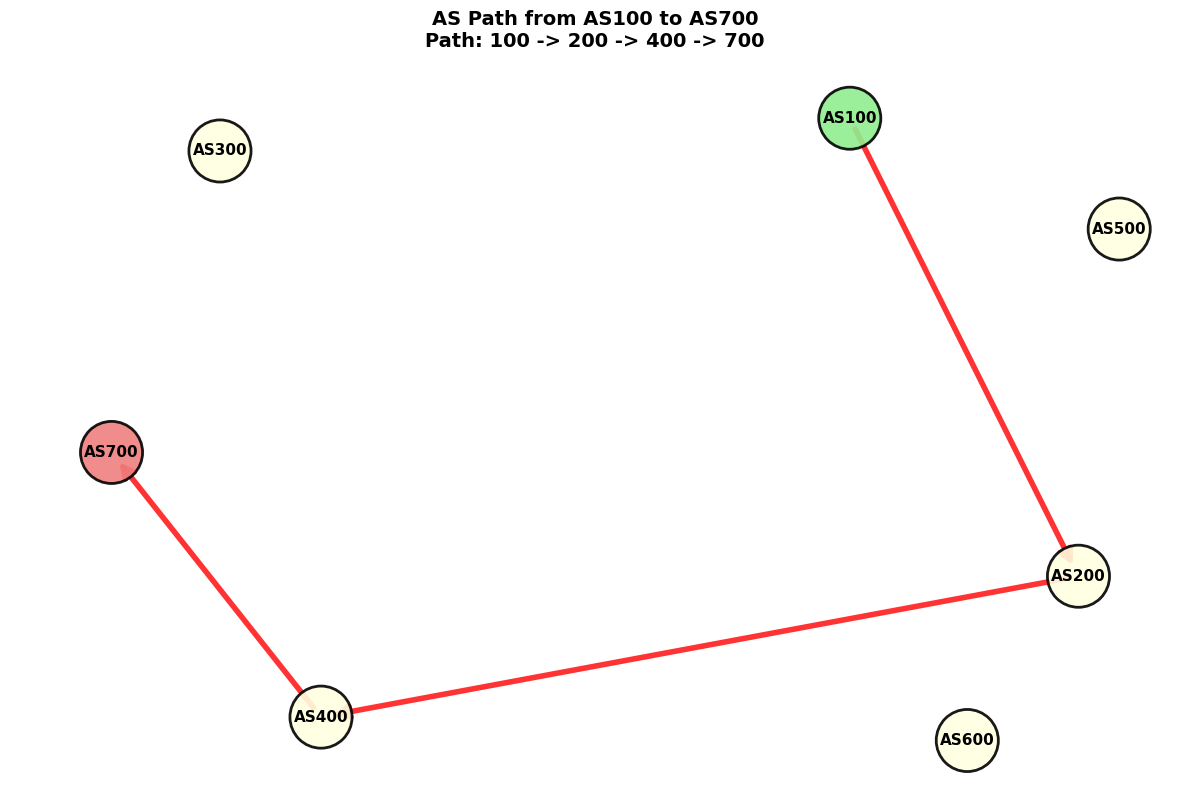

In [20]:
visualize_as_path(routers, 100, 700)

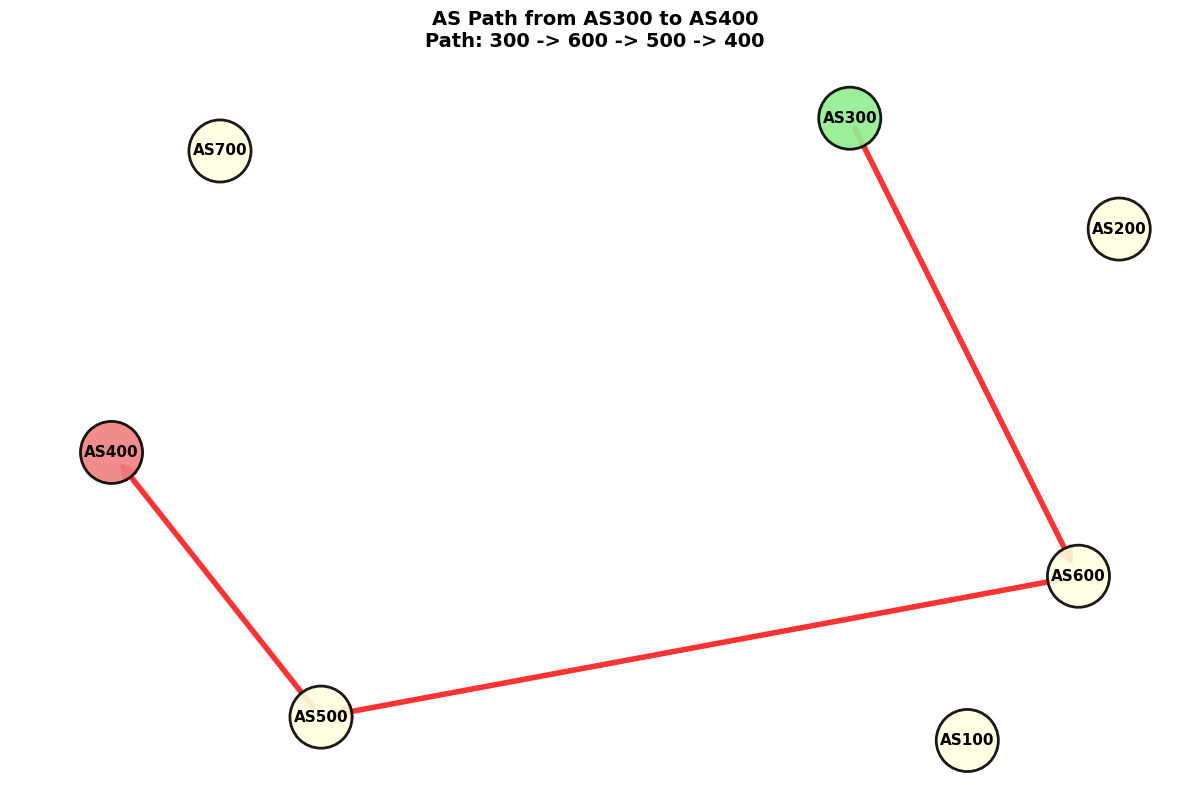

In [21]:
visualize_as_path(routers, 300, 400)

In [22]:
intra_as_topology = {
    100: {
        'R1': {'R2': 2, 'R3': 5},
        'R2': {'R1': 2, 'R3': 3, 'R4': 1},
        'R3': {'R1': 5, 'R2': 3, 'R4': 2},
        'R4': {'R2': 1, 'R3': 2}
    },
    200: {
        'R1': {'R2': 1, 'R3': 4},
        'R2': {'R1': 1, 'R3': 2},
        'R3': {'R1': 4, 'R2': 2}
    },
    400: {
        'R1': {'R2': 3, 'R3': 1},
        'R2': {'R1': 3, 'R3': 2, 'R4': 4},
        'R3': {'R1': 1, 'R2': 2, 'R4': 1},
        'R4': {'R2': 4, 'R3': 1}
    },
    700: {
        'R1': {'R2': 2},
        'R2': {'R1': 2, 'R3': 3},
        'R3': {'R2': 3}
    }
}

In [26]:
def simulate_intra_as(as_number, topology):
    routers = {}
    
    for router_id in topology.keys():
        routers[router_id] = IntraASRouter(router_id, as_number)
    
    for router_id, neighbors in topology.items():
        for neighbor_id, cost in neighbors.items():
            routers[router_id].add_neighbor(neighbor_id, cost)
    
    print(f"\nIntra-AS Routing for AS {as_number} (Using Dijkstra's Algorithm)")
    print("=" * 70)
    
    for router_id, router in routers.items():
        router.dijkstra(routers)
    
    for router_id in sorted(routers.keys()):
        print(f"\nRouting Table for Router {router_id} in AS {as_number}:")
        print("-" * 50)
        print(f"{'Destination':<15} {'Cost':<10} {'Next Hop':<15}")
        print("-" * 50)
        if routers[router_id].routing_table:
            for dest in sorted(routers[router_id].routing_table.keys()):
                cost, next_hop = routers[router_id].routing_table[dest]
                print(f"{dest:<15} {cost:<10} {next_hop:<15}")
        else:
            print("(No routes)")
        print("-" * 50)
    
    return routers

In [27]:
def visualize_intra_as(as_number, topology, routers):
    G = nx.Graph()
    
    for router, neighbors in topology.items():
        for neighbor, cost in neighbors.items():
            G.add_edge(router, neighbor, weight=cost)
    
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 8))
    
    nx.draw_networkx_nodes(G, pos, node_color='lightcyan', 
                          node_size=1500, alpha=0.9,
                          edgecolors='black', linewidths=2)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.6)
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=9)
    
    plt.title(f"Intra-AS Topology for AS {as_number}\n(Dijkstra's Algorithm)", 
             fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [28]:
def visualize_combined_routing(bgp_routers, source_as, dest_as, intra_topology):
    if dest_as not in bgp_routers[source_as].routing_table:
        print(f"No BGP path from AS {source_as} to AS {dest_as}")
        return
    
    as_path, cost = bgp_routers[source_as].routing_table[dest_as]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    G_bgp = nx.DiGraph()
    for i in range(len(as_path) - 1):
        G_bgp.add_edge(f"AS{as_path[i]}", f"AS{as_path[i+1]}")
    
    all_as = set()
    for router in bgp_routers.values():
        all_as.add(f"AS{router.as_number}")
    
    for node in all_as:
        if node not in G_bgp.nodes():
            G_bgp.add_node(node)
    
    pos_bgp = nx.spring_layout(G_bgp, seed=42, k=2)
    
    node_colors = ['lightgreen' if node == f"AS{source_as}" 
                   else 'lightcoral' if node == f"AS{dest_as}"
                   else 'lightyellow' for node in G_bgp.nodes()]
    
    nx.draw_networkx_nodes(G_bgp, pos_bgp, node_color=node_colors, 
                          node_size=2000, alpha=0.9,
                          edgecolors='black', linewidths=2, ax=ax1)
    nx.draw_networkx_labels(G_bgp, pos_bgp, font_size=11, font_weight='bold', ax=ax1)
    
    path_edges = [(f"AS{as_path[i]}", f"AS{as_path[i+1]}") for i in range(len(as_path)-1)]
    nx.draw_networkx_edges(G_bgp, pos_bgp, path_edges, width=4, alpha=0.8, 
                          edge_color='red', arrows=True, 
                          arrowsize=20, arrowstyle='->', ax=ax1)
    
    ax1.set_title(f"Inter-AS BGP Path (Path-Vector/Bellman-Ford)\nAS{source_as} → AS{dest_as}\nPath: {' → '.join(map(str, as_path))}", 
                 fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    as_to_show = as_path[0] if as_path[0] in intra_topology else (as_path[1] if len(as_path) > 1 and as_path[1] in intra_topology else None)
    
    if as_to_show and as_to_show in intra_topology:
        G_intra = nx.Graph()
        for router, neighbors in intra_topology[as_to_show].items():
            for neighbor, link_cost in neighbors.items():
                G_intra.add_edge(router, neighbor, weight=link_cost)
        
        pos_intra = nx.spring_layout(G_intra, seed=42)
        
        nx.draw_networkx_nodes(G_intra, pos_intra, node_color='lightcyan', 
                              node_size=1500, alpha=0.9,
                              edgecolors='black', linewidths=2, ax=ax2)
        nx.draw_networkx_labels(G_intra, pos_intra, font_size=10, font_weight='bold', ax=ax2)
        nx.draw_networkx_edges(G_intra, pos_intra, width=2, alpha=0.6, ax=ax2)
        
        edge_labels = nx.get_edge_attributes(G_intra, 'weight')
        nx.draw_networkx_edge_labels(G_intra, pos_intra, edge_labels, font_size=9, ax=ax2)
        
        ax2.set_title(f"Intra-AS Routing in AS{as_to_show} (Dijkstra's Algorithm)\nShortest Paths within AS", 
                     fontsize=12, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, f"No intra-AS topology\ndefined for AS{as_to_show}", 
                ha='center', va='center', fontsize=12, transform=ax2.transAxes)
        ax2.set_title(f"Intra-AS Routing (Dijkstra)", fontsize=12, fontweight='bold')
    
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
    print(f"COMBINED ROUTING: AS{source_as} → AS{dest_as}")
    print("=" * 70)
    print(f"\nInter-AS (BGP - Path Vector/Bellman-Ford):")
    print(f"  AS Path: {' → '.join(map(str, as_path))}")
    print(f"  Path Length: {len(as_path) - 1} AS hops")
    if as_to_show:
        print(f"\nIntra-AS (OSPF/IS-IS - Dijkstra):")
        print(f"  Within AS{as_to_show}: Uses Dijkstra's shortest path algorithm")
        print(f"  Routers communicate via link-state advertisements")
    print("=" * 70)

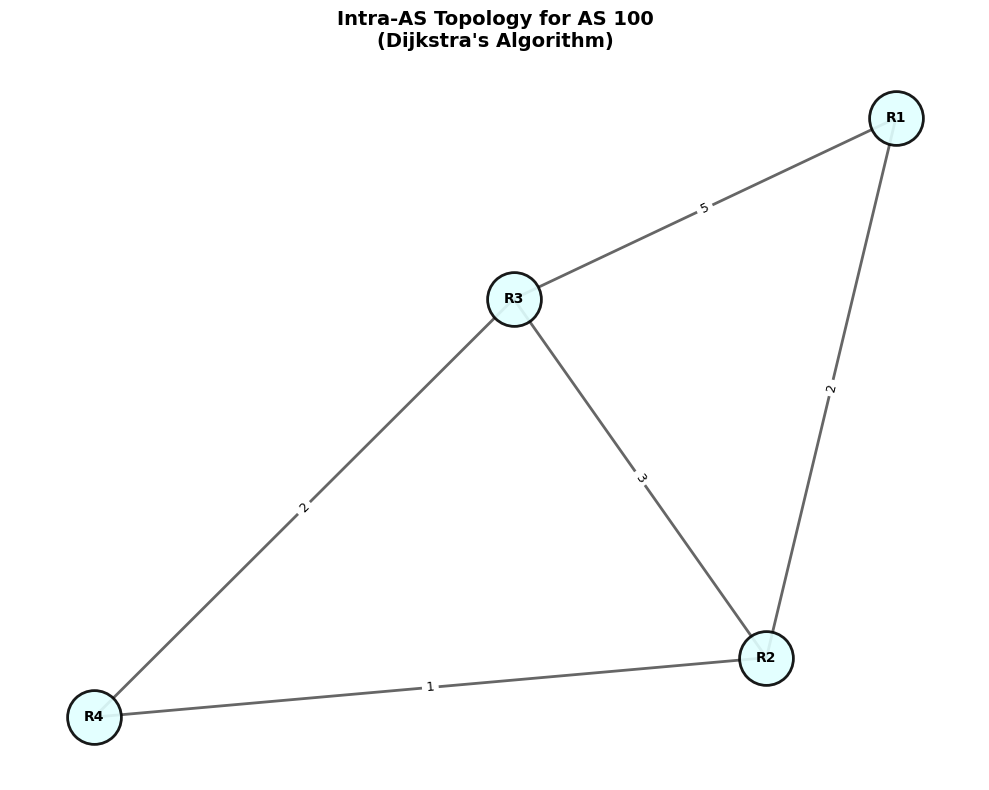

In [29]:
visualize_intra_as(100, intra_as_topology[100], None)

In [30]:
intra_routers_100 = simulate_intra_as(100, intra_as_topology[100])


Intra-AS Routing for AS 100 (Using Dijkstra's Algorithm)

Routing Table for Router R1 in AS 100:
--------------------------------------------------
Destination     Cost       Next Hop       
--------------------------------------------------
R2              2          R2             
R3              5          R3             
R4              3          R2             
--------------------------------------------------

Routing Table for Router R2 in AS 100:
--------------------------------------------------
Destination     Cost       Next Hop       
--------------------------------------------------
R1              2          R1             
R3              3          R3             
R4              1          R4             
--------------------------------------------------

Routing Table for Router R3 in AS 100:
--------------------------------------------------
Destination     Cost       Next Hop       
--------------------------------------------------
R1              5          

In [31]:
intra_routers_200 = simulate_intra_as(200, intra_as_topology[200])


Intra-AS Routing for AS 200 (Using Dijkstra's Algorithm)

Routing Table for Router R1 in AS 200:
--------------------------------------------------
Destination     Cost       Next Hop       
--------------------------------------------------
R2              1          R2             
R3              3          R2             
--------------------------------------------------

Routing Table for Router R2 in AS 200:
--------------------------------------------------
Destination     Cost       Next Hop       
--------------------------------------------------
R1              1          R1             
R3              2          R3             
--------------------------------------------------

Routing Table for Router R3 in AS 200:
--------------------------------------------------
Destination     Cost       Next Hop       
--------------------------------------------------
R1              3          R2             
R2              2          R2             
---------------------------

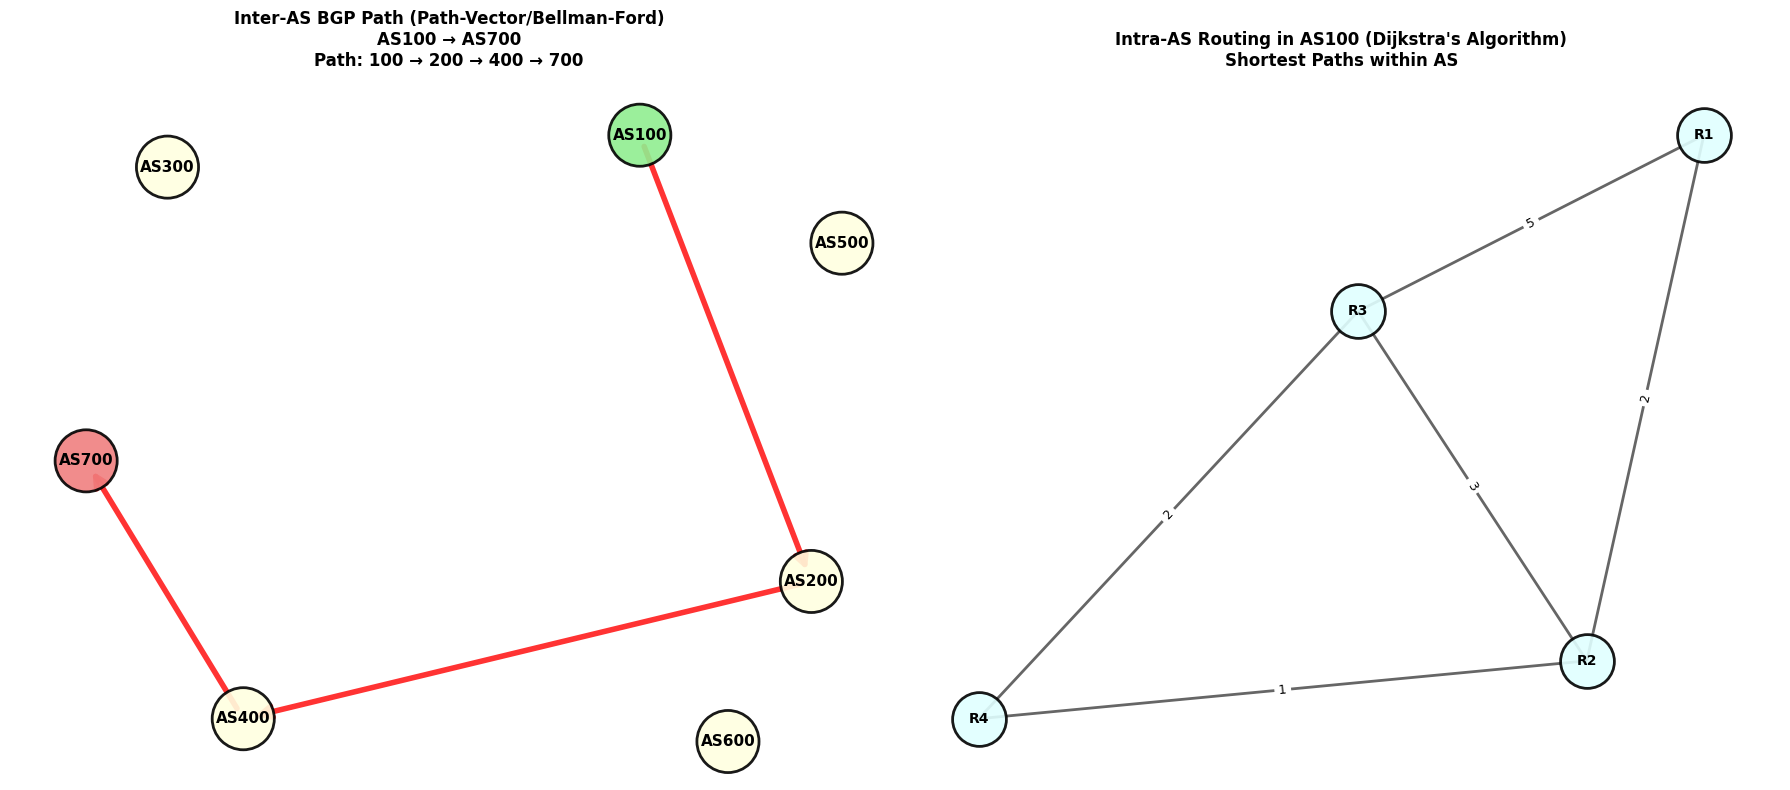


COMBINED ROUTING: AS100 → AS700

Inter-AS (BGP - Path Vector/Bellman-Ford):
  AS Path: 100 → 200 → 400 → 700
  Path Length: 3 AS hops

Intra-AS (OSPF/IS-IS - Dijkstra):
  Within AS100: Uses Dijkstra's shortest path algorithm
  Routers communicate via link-state advertisements


In [32]:
visualize_combined_routing(routers, 100, 700, intra_as_topology)

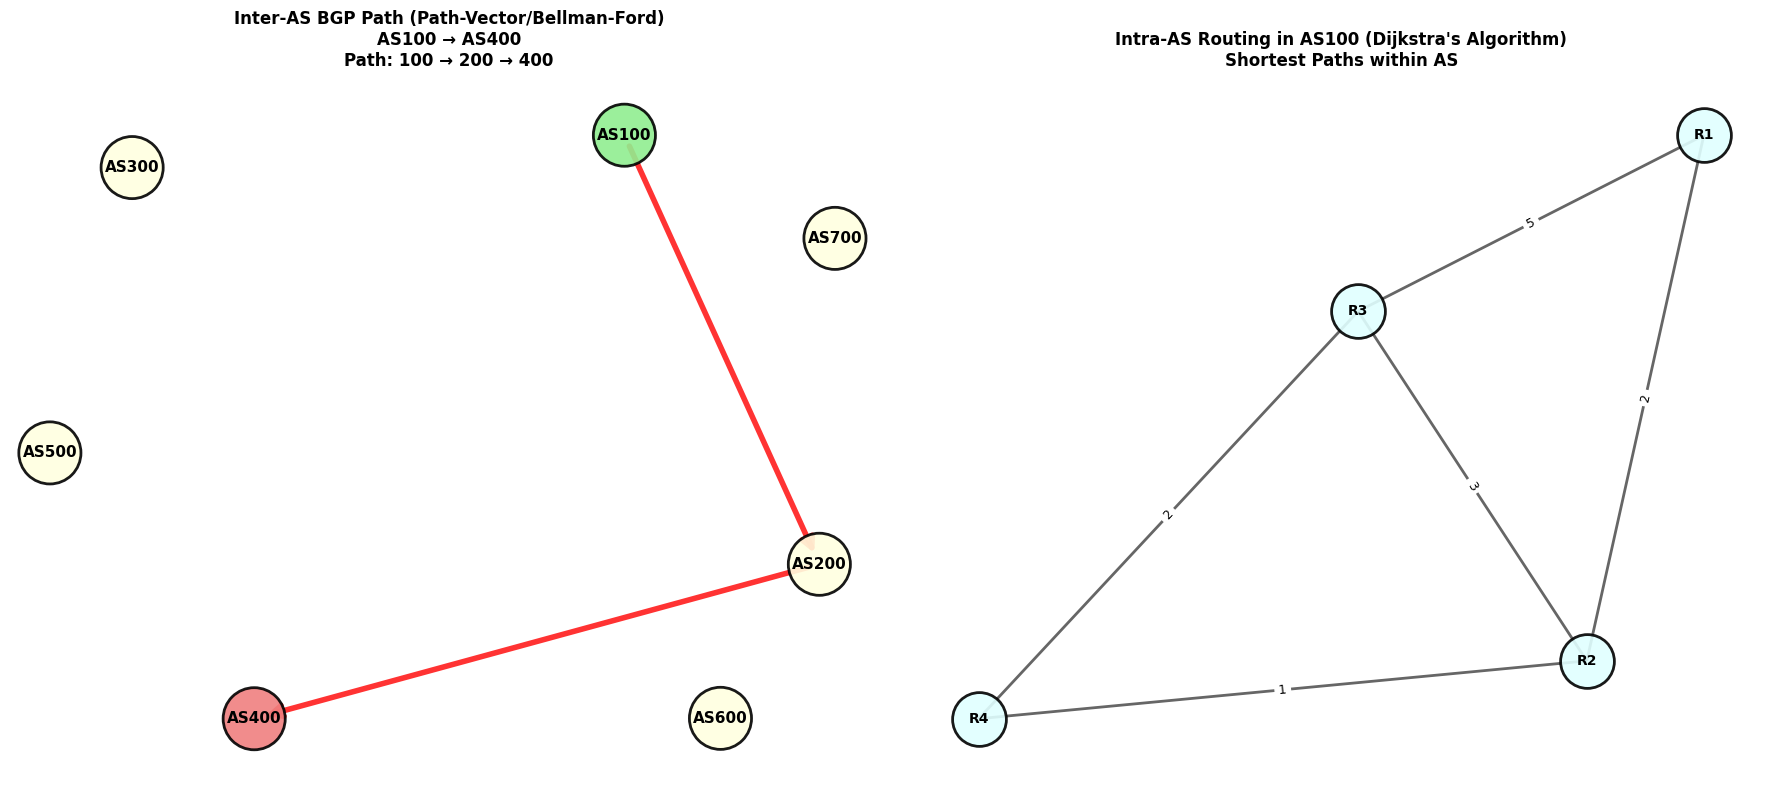


COMBINED ROUTING: AS100 → AS400

Inter-AS (BGP - Path Vector/Bellman-Ford):
  AS Path: 100 → 200 → 400
  Path Length: 2 AS hops

Intra-AS (OSPF/IS-IS - Dijkstra):
  Within AS100: Uses Dijkstra's shortest path algorithm
  Routers communicate via link-state advertisements


In [33]:
visualize_combined_routing(routers, 100, 400, intra_as_topology)